In [1]:
import pandas as pd
import pickle
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
pip install gensim konlpy

# ◆ 1. LDA를 위한 데이터 전처리
* 1.1. 전체 단어의 사전 만들고 각 문서에 매칭하기
    > 단어들이 문서에 얼마나 위치해 있는지 분포를 파악해야하기 때문에 분석할 전체 데이터 대상으로
    사용된 단어의 사전을 생성해야한다,


In [3]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import gensim
from gensim import corpora, models
from gensim.corpora import Dictionary

In [6]:
with open('/content/drive/My Drive/data/DCX/DCX수업자료/result.pkl','rb') as f:
    df = pickle.load(f)

### 1.1 전체 단어의 사전 만들고 각 문서에 매칭하기

In [7]:
df_cluster0 = df[df['cluster'] ==  0]


In [8]:
df_cluster0.head()

,Date,Name,Score,Review,like,re_reveiw,tagged_review,vector,cluster
2,2020년 1월 8일,Nicholas Jun,1,위례 사는 신혼 부부입니다. TV랑 공기청정기는 잘 연동시켰습니다. 오래 걸리지도 ...,0,위례 사는 신혼 부부입니다. TV랑 공기청정기는 잘 연동시켰습니다. 오래 걸리지도 ...,"[위례, 살다, 신혼, 부부, 공기청정기, 자다, 연동, 걸리다, 않다, 문제, 김...","[1.753042, -0.07281258, -0.5188711, 0.657367, ...",0
6,2020년 1월 17일,박용진,1,스타일러 사용중 입니다. 와이파이 등록해서 원격제어 사용하고 있었습니다만 갑자기 와...,4,스타일러 사용중 입니다. 와이파이 등록해서 원격제어 사용하고 있었습니다만 갑자기 와...,"[스타, 이르다, 사용, 와이파이, 등록, 격, 제어, 사용, 갑자기, 와이파이, ...","[1.0564067, -0.50211126, 0.34154308, 0.2294804...",0
7,2020년 1월 17일,Jihee Yoo,1,에어컨이랑 겨우겨우 연결됐는데 제품이 존재하지않는다고 다시 연결하라는 메세지 떠서 ...,1,에어컨이랑 겨우겨우 연결됐는데 제품이 존재하지않는다고 다시 연결하라는 메세지 떠서 ...,"[에어컨, 연결, 돼다, 제품, 존재, 않다, 다시, 연결하다, 메세지, 뜨다, 다...","[0.73628646, -0.025873426, 0.37017214, -0.4830...",0
8,2020년 1월 20일,haeseong yun,1,안드로이드에서 다음 버튼이 없음 등록에서 다음 단계로 자체가 안넘어감 한달 넘음 아...,0,안드로이드에서 다음 버튼이 없음 등록에서 다음 단계로 자체가 안넘어감 한달 넘음 아...,"[안드로이드, 버튼, 없다, 등록, 단계, 자체, 넘어가다, 달, 넘다, 아이폰, ...","[1.1674384, -0.6331193, 0.58134526, 0.9899267,...",0
11,2019년 12월 18일,이성우,1,11년차 SW 엔지니어 입니다. 정말 한심하게 보이네요. 업데이트 하고 약관동의 다...,5,년차 SW 엔지니어 입니다. 정말 한심하게 보이네요. 업데이트 하고 약관동의 다시...,"[년차, 엔지니어, 정말, 한심하다, 보이다, 업데이트, 약관, 동의, 다시, 제품...","[1.5864395, -0.4519122, 0.41209608, 1.0360653,...",0


In [9]:
all_documents = list(df_cluster0['tagged_review'])
dictionary = corpora.Dictionary(all_documents)
dictionary.filter_extremes(no_below=3, no_above=0.8)
corpus = [dictionary.doc2bow(doc) for doc in all_documents]

# ◆ 2. LDA모델 만들기
* 2.1 LDA 기본 모델 만들기
* 2.2 LDA 토픽개수 선정
* 2.3 선정한 토픽 개수로 Action 넘버 매칭

### 2.1 LDA 기본 모델 만들기

In [10]:
topic_num = 3

ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = topic_num, id2word = dictionary, passes = 20, iterations= 50, random_state= 42)



In [11]:
ldamodel.print_topics(num_words = 5)

[(0, '0.025*"연결" + 0.023*"안되다" + 0.021*"등록" + 0.021*"좋다" + 0.019*"업데이트"'),
 (1, '0.034*"앱" + 0.021*"안되다" + 0.020*"없다" + 0.017*"사용" + 0.013*"실행"'),
 (2, '0.057*"안되다" + 0.054*"연결" + 0.030*"등록" + 0.026*"와이파이" + 0.025*"에어컨"')]

### 2.2 LDA 토픽 수 선정
* cohearence & perplexcity

In [12]:
from gensim.models import CoherenceModel #coherence 모델 라이브러리
import matplotlib.pyplot as plt #그래프 그리기
import numpy as np

In [13]:
for i in range(0,21):
    print(ldamodel.get_document_topics(corpus[i]))

[(1, 0.8888463), (2, 0.102337025)]
[(1, 0.22397034), (2, 0.7673998)]
[(0, 0.27265185), (1, 0.010844288), (2, 0.7165039)]
[(0, 0.43655083), (1, 0.5082104), (2, 0.05523876)]
[(0, 0.7860601), (1, 0.20770618)]
[(0, 0.021016639), (1, 0.018062292), (2, 0.96092105)]
[(0, 0.19246837), (1, 0.24203864), (2, 0.565493)]
[(0, 0.010500996), (1, 0.98009324)]
[(0, 0.27770045), (1, 0.016685141), (2, 0.7056144)]
[(0, 0.707164), (1, 0.012626652), (2, 0.28020933)]
[(0, 0.50139546), (2, 0.48952836)]
[(0, 0.5279715), (1, 0.01399697), (2, 0.45803154)]
[(0, 0.023592595), (1, 0.22049688), (2, 0.7559106)]
[(0, 0.20649664), (1, 0.026323168), (2, 0.7671802)]
[(0, 0.16735996), (1, 0.01502146), (2, 0.81761855)]
[(0, 0.31142083), (1, 0.015508525), (2, 0.67307067)]
[(0, 0.024006315), (1, 0.023577087), (2, 0.9524166)]
[(0, 0.81132346), (1, 0.030583257), (2, 0.15809327)]
[(0, 0.5471795), (1, 0.13857467), (2, 0.31424582)]
[(0, 0.02366184), (1, 0.027002633), (2, 0.9493356)]
[(0, 0.21079215), (1, 0.042134054), (2, 0.74707

In [14]:
perplexity_score = ldamodel.log_perplexity(corpus)
perplexity_score

-6.144035210983633

In [15]:
top_n = 3
coherence_model = CoherenceModel(model=ldamodel, texts= all_documents, dictionary=dictionary, topn = top_n)
coherence_score = coherence_model.get_coherence()
coherence_score

0.6911533946219973

> 2.2.1 Perplexity 그래프 만들기

In [16]:
perplexity_values = []

for i in range(2,10):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = i, id2word = dictionary)
    perplexity_v = ldamodel.log_perplexity(corpus)
    perplexity_values.append(perplexity_v)



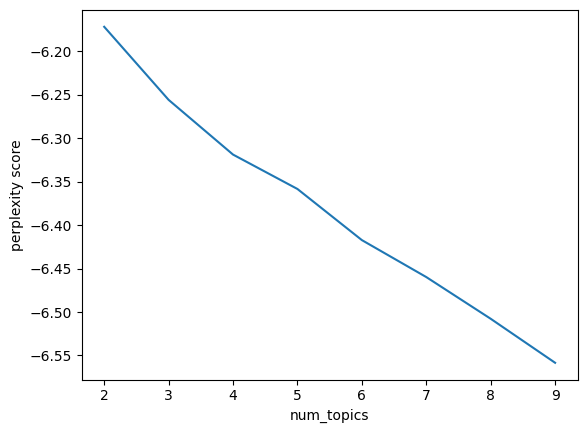

In [17]:
x = range(2,10)
plt.plot(x, perplexity_values)
plt.xlabel('num_topics')
plt.ylabel('perplexity score')
plt.show()

> 2.2.1 Cohearence 그래프 만들기

In [18]:
cohernce_values = []
top_n = 3

for i in tqdm(range(2,10)):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = i, id2word = dictionary)

    coherence_model = CoherenceModel(model=ldamodel, texts= all_documents, dictionary=dictionary, topn = top_n)
    coherence_v = coherence_model.get_coherence()
    cohernce_values.append(coherence_v)

100%|██████████| 8/8 [00:16<00:00,  2.00s/it]


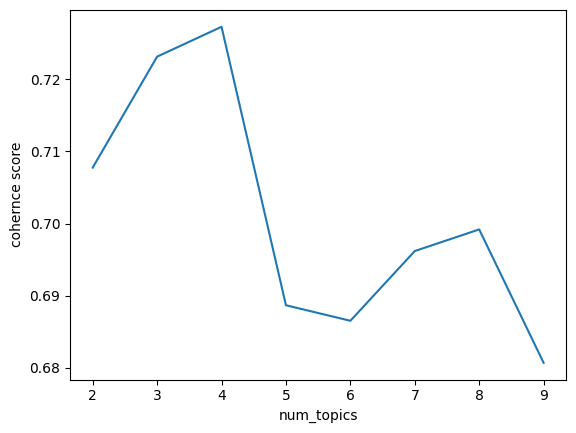

In [19]:
x = range(2,10)
plt.plot(x, cohernce_values)
plt.xlabel('num_topics')
plt.ylabel('cohernce score')
plt.show()

### 2.3 선정한 토픽 개수로 Action 넘버 매칭

In [20]:
topic_num = 3

ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = topic_num, id2word = dictionary, passes = 20, iterations= 50, random_state= 42)

In [21]:
ldamodel.get_document_topics(corpus)[1]

[(1, 0.22397843), (2, 0.7673918)]

In [22]:
action_align = []

for doc in tqdm(ldamodel.get_document_topics(corpus)):
    label = []
    value = []

    for score in doc:
        label.append(score[0])
        value.append(score[1])

    max_index = np.argmax(value) #확률이 가장 큰 값(value값이 큰값들만 선택해서 인덱스로)
    action_align.append(label[max_index])

100%|██████████| 1816/1816 [00:00<00:00, 1937.75it/s]


In [23]:
 action_align[:20]

[1, 2, 2, 1, 0, 2, 2, 1, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2]

In [24]:
df_cluster0['action_cluster'] = action_align
df_cluster0

,Date,Name,Score,Review,like,re_reveiw,tagged_review,vector,cluster,action_cluster
2,2020년 1월 8일,Nicholas Jun,1,위례 사는 신혼 부부입니다. TV랑 공기청정기는 잘 연동시켰습니다. 오래 걸리지도 ...,0,위례 사는 신혼 부부입니다. TV랑 공기청정기는 잘 연동시켰습니다. 오래 걸리지도 ...,"[위례, 살다, 신혼, 부부, 공기청정기, 자다, 연동, 걸리다, 않다, 문제, 김...","[1.753042, -0.07281258, -0.5188711, 0.657367, ...",0,1
6,2020년 1월 17일,박용진,1,스타일러 사용중 입니다. 와이파이 등록해서 원격제어 사용하고 있었습니다만 갑자기 와...,4,스타일러 사용중 입니다. 와이파이 등록해서 원격제어 사용하고 있었습니다만 갑자기 와...,"[스타, 이르다, 사용, 와이파이, 등록, 격, 제어, 사용, 갑자기, 와이파이, ...","[1.0564067, -0.50211126, 0.34154308, 0.2294804...",0,2
7,2020년 1월 17일,Jihee Yoo,1,에어컨이랑 겨우겨우 연결됐는데 제품이 존재하지않는다고 다시 연결하라는 메세지 떠서 ...,1,에어컨이랑 겨우겨우 연결됐는데 제품이 존재하지않는다고 다시 연결하라는 메세지 떠서 ...,"[에어컨, 연결, 돼다, 제품, 존재, 않다, 다시, 연결하다, 메세지, 뜨다, 다...","[0.73628646, -0.025873426, 0.37017214, -0.4830...",0,2
8,2020년 1월 20일,haeseong yun,1,안드로이드에서 다음 버튼이 없음 등록에서 다음 단계로 자체가 안넘어감 한달 넘음 아...,0,안드로이드에서 다음 버튼이 없음 등록에서 다음 단계로 자체가 안넘어감 한달 넘음 아...,"[안드로이드, 버튼, 없다, 등록, 단계, 자체, 넘어가다, 달, 넘다, 아이폰, ...","[1.1674384, -0.6331193, 0.58134526, 0.9899267,...",0,1
11,2019년 12월 18일,이성우,1,11년차 SW 엔지니어 입니다. 정말 한심하게 보이네요. 업데이트 하고 약관동의 다...,5,년차 SW 엔지니어 입니다. 정말 한심하게 보이네요. 업데이트 하고 약관동의 다시...,"[년차, 엔지니어, 정말, 한심하다, 보이다, 업데이트, 약관, 동의, 다시, 제품...","[1.5864395, -0.4519122, 0.41209608, 1.0360653,...",0,0
...,...,...,...,...,...,...,...,...,...,...
3564,2018년 4월 28일,LEE KS,5,필요할때 적절하게 유용한 메시지를 날려주네요,0,필요할때 적절하게 유용한 메시지를 날려주네요,"[필요하다, 적절하다, 유용하다, 메시지, 날다]","[-0.23097914, 0.10075833, 0.17275853, 0.354202...",0,1
3566,2017년 10월 2일,김수아,2,잘쓰고있었는데 제품정보 다날아갔어요,0,잘쓰고있었는데 제품정보 다날아갔어요,"[잘쓰다, 제품, 정보, 날아가다]","[-0.21255945, -0.3263192, 0.09371999, -0.01842...",0,0
3569,2017년 5월 18일,노래여왕,1,어떻게 하라는거예요? 설정하는데 종일 씨름하다 삭제...,0,어떻게 하라는거예요? 설정하는데 종일 씨름하다 삭제...,"[하라, 거, 설정, 종일, 씨름, 삭제]","[-0.10588539, -0.04776544, 0.072160415, -0.537...",0,1
3571,2018년 7월 13일,KoonSeok Lee,5,센서를 너무 잘 쓰고 있어요,0,센서를 너무 잘 쓰고 있어요,"[센서, 자다, 쓰다]","[0.09033106, -0.19779938, 0.039585683, 0.11875...",0,1


In [25]:
df_cluster0['action_cluster'].value_counts()

,count
action_cluster,
2,663
0,597
1,556


# ◆ 3. LDA 시각화 (LDAvis)


In [28]:
pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 40.8 MB/s eta 0:00:00


In [29]:
#경고무시
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

#LDA 시각화 라이브러리
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [30]:
prepared_data = gensimvis.prepare(ldamodel, corpus, dictionary)
pyLDAvis.save_html(prepared_data, 'lda_cluster0.html')
pyLDAvis.display(prepared_data)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

# ◆ 4. LDA 분석을 위한 후작업
* LDAvis와 LDA모델의 토픽 넘버 매칭
* LDAvis 결과와 LDA모델의 결과를 보고 직접 매칭해야한다.

In [31]:
topics = ldamodel.show_topics(num_words = 10, formatted=True)


for id , topic_desc in topics:
    print(f'topic id : {id}, description : {topic_desc}')

topic id : 0, description : 0.025*"연결" + 0.023*"안되다" + 0.021*"등록" + 0.021*"좋다" + 0.019*"업데이트" + 0.018*"자다" + 0.016*"어플" + 0.016*"제품" + 0.014*"사용" + 0.013*"에어컨"
topic id : 1, description : 0.034*"앱" + 0.021*"안되다" + 0.020*"없다" + 0.017*"사용" + 0.013*"실행" + 0.013*"만들다" + 0.012*"않다" + 0.011*"뜨다" + 0.011*"어플" + 0.009*"제품"
topic id : 2, description : 0.057*"안되다" + 0.054*"연결" + 0.030*"등록" + 0.026*"와이파이" + 0.025*"에어컨" + 0.019*"제품" + 0.016*"다시" + 0.013*"연결하다" + 0.013*"계속" + 0.012*"뜨다"


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [32]:
new_action_topic = []

for i in tqdm(df_cluster0.action_cluster):
    if i == 0:
        n = 1
    elif i == 1 :
        n = 2
    else :
        n = 3

    new_action_topic.append(n)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [33]:
df_cluster0.action_cluster = new_action_topic

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [34]:
df_cluster0['action_cluster'].value_counts()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

,count
action_cluster,
3,663
1,597
2,556


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [35]:
df_cluster0 = df_cluster0[['Review','tagged_review','cluster','action_cluster']]
df_cluster0

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

,Review,tagged_review,cluster,action_cluster
2,위례 사는 신혼 부부입니다. TV랑 공기청정기는 잘 연동시켰습니다. 오래 걸리지도 ...,"[위례, 살다, 신혼, 부부, 공기청정기, 자다, 연동, 걸리다, 않다, 문제, 김...",0,2
6,스타일러 사용중 입니다. 와이파이 등록해서 원격제어 사용하고 있었습니다만 갑자기 와...,"[스타, 이르다, 사용, 와이파이, 등록, 격, 제어, 사용, 갑자기, 와이파이, ...",0,3
7,에어컨이랑 겨우겨우 연결됐는데 제품이 존재하지않는다고 다시 연결하라는 메세지 떠서 ...,"[에어컨, 연결, 돼다, 제품, 존재, 않다, 다시, 연결하다, 메세지, 뜨다, 다...",0,3
8,안드로이드에서 다음 버튼이 없음 등록에서 다음 단계로 자체가 안넘어감 한달 넘음 아...,"[안드로이드, 버튼, 없다, 등록, 단계, 자체, 넘어가다, 달, 넘다, 아이폰, ...",0,2
11,11년차 SW 엔지니어 입니다. 정말 한심하게 보이네요. 업데이트 하고 약관동의 다...,"[년차, 엔지니어, 정말, 한심하다, 보이다, 업데이트, 약관, 동의, 다시, 제품...",0,1
...,...,...,...,...
3564,필요할때 적절하게 유용한 메시지를 날려주네요,"[필요하다, 적절하다, 유용하다, 메시지, 날다]",0,2
3566,잘쓰고있었는데 제품정보 다날아갔어요,"[잘쓰다, 제품, 정보, 날아가다]",0,1
3569,어떻게 하라는거예요? 설정하는데 종일 씨름하다 삭제...,"[하라, 거, 설정, 종일, 씨름, 삭제]",0,2
3571,센서를 너무 잘 쓰고 있어요,"[센서, 자다, 쓰다]",0,2


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [36]:
df_cluster0.to_csv('Cluster0.csv', encoding = 'utf-8-sig')

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [37]:
with open('Cluster0.pkl', 'wb') as f :
    pickle.dump(df_cluster0, f)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag